# Example 4: Calibration of an epidemic model via Covid-19 data

## Data: Covid-19

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import sample
import scipy.stats as sps
from surmise.calibration import calibrator 
from surmise.emulation import emulator

In [2]:
# Read data 
real_data = np.loadtxt('real_observations.csv', delimiter=',')
description = np.loadtxt('observation_description.csv', delimiter=',',dtype='object')
param_values = 1/np.loadtxt('param_values.csv', delimiter=',')
func_eval = np.loadtxt('func_eval.csv', delimiter=',')
param_values_test = 1/np.loadtxt('param_values_test.csv', delimiter=',')
func_eval_test = np.loadtxt('func_eval_test.csv', delimiter=',')

In [3]:
# Remove the initial 30-days time period from the data
keepinds = np.squeeze(np.where(description[:,0].astype('float') > 30))
real_data = real_data[keepinds]
description = description[keepinds, :]
func_eval = func_eval[:,keepinds]
func_eval_test = func_eval_test[:, keepinds]

In [4]:
print('N:', func_eval.shape[0])
print('D:', param_values.shape[1])
print('M:', real_data.shape[0])
print('P:', description.shape[1])

N: 2000
D: 10
M: 402
P: 2


In [5]:
# Get the random sample of 500
rndsample = sample(range(0, 2000), 500)
func_eval_rnd = func_eval[rndsample, :]
param_values_rnd = param_values[rndsample, :]

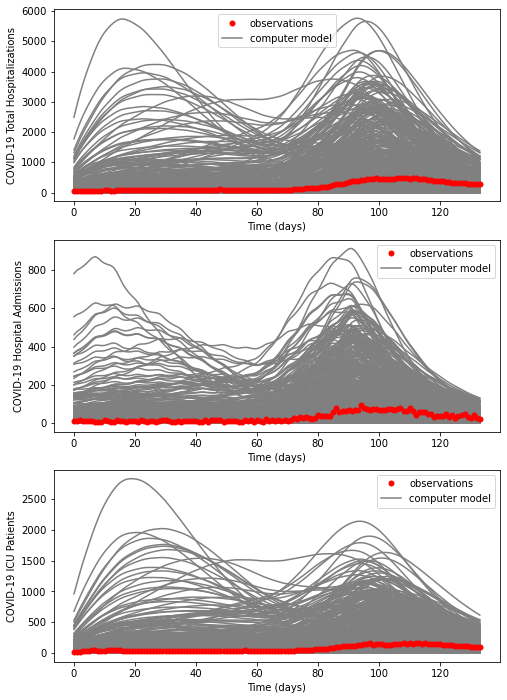

In [6]:
def plot_model_data(description, func_eval, real_data, param_values):
    '''
    Plots a list of profiles in the same figure. Each profile corresponds
    to a simulation replica for the given instance.
    '''
    plt.rcParams["font.size"] = "10"
    N = len(param_values)
    D = description.shape[1]
    T = len(np.unique(description[:,0]))
    type_no = len(np.unique(description[:,1]))
    fig, axs = plt.subplots(type_no, figsize=(8, 12))

    for j in range(type_no):
        for i in range(N):
            p2 = axs[j].plot(range(T), func_eval[i,(j*T):(j*T + T)], color='grey')
        p1 = axs[j].plot(range(T), real_data[(j*T):(j*T + T)], 'ro' ,markersize = 5, color='red')
        if j == 0:
            axs[j].set_ylabel('COVID-19 Total Hospitalizations')
        elif j == 1:
            axs[j].set_ylabel('COVID-19 Hospital Admissions')
        elif j == 2:
            axs[j].set_ylabel('COVID-19 ICU Patients')
        axs[j].set_xlabel('Time (days)')
        axs[j].legend([p1[0], p2[0]], ['observations', 'computer model'])
    plt.show()
    
plot_model_data(description, func_eval_rnd, real_data, param_values_rnd)

## Model emulation

In [8]:
x = np.hstack((np.reshape(np.tile(range(134), 3), (402, 1)),
              np.reshape(np.tile(np.array(('tothosp','totadmiss','icu')),134), (402, 1))))
x =  np.array(x, dtype='object')

In [9]:
# (No filter) Fit an emulator via 'PCGP'
emulator_1 = emulator(x=x, theta=param_values_rnd, f=func_eval_rnd.T, method='PCGP') 

Function supplementtheta not found in module!
PCGP considering  7 PCs


In [10]:
# (No filter) Fit an emulator via 'PCGPwM'
emulator_2 = emulator(x=x, theta=param_values_rnd, f=func_eval_rnd.T, method='PCGPwM', 
                      args = {'epsilon': 1.5, 'hypregmean': -10, 'hypregLB': -20}) 

PCGPwM considering  11 PCs


### Comparison of emulation methodologies

In [11]:
# Compare emulators
pred_1_test = emulator_1.predict(x, param_values_test)
pred_mean_test_1 = pred_1_test.mean()
print("Rsq = ", 1 - np.sum(np.square(pred_mean_test_1 - func_eval_test.T))/np.sum(np.square(func_eval_test - np.mean(func_eval_test.T, axis = 1))))
print('MSE = ', np.mean(np.sum(np.square(pred_mean_test_1 - func_eval_test.T), axis = 1)))

pred_2_test = emulator_2.predict(x, param_values_test)
pred_mean_2_test = pred_2_test.mean()
print("Rsq = ", 1 - np.sum(np.square(pred_mean_2_test - func_eval_test.T))/np.sum(np.square(func_eval_test - np.mean(func_eval_test.T, axis = 1))))
print('MSE = ', np.mean(np.sum(np.square(pred_mean_2_test - func_eval_test.T), axis = 1)))

Rsq =  0.8437015643111756
MSE =  53759754.53153551
Rsq =  0.988628298157786
MSE =  3911362.880562405


## Model calibration

In [12]:
def plot_pred_interval(cal):
    pr = cal.predict(x)
    rndm_m = pr.rnd(s = 1000)
    plt.rcParams["font.size"] = "10"
    fig, axs = plt.subplots(3, figsize=(8, 12))

    for j in range(3):
        upper = np.percentile(rndm_m[:, j*134 : (j + 1)*134], 97.5, axis = 0)
        lower = np.percentile(rndm_m[:, j*134 : (j + 1)*134], 2.5, axis = 0)
        median = np.percentile(rndm_m[:, j*134 : (j + 1)*134], 50, axis = 0)
        p1 = axs[j].plot(median, color = 'black')
        axs[j].fill_between(range(0, 134), lower, upper, color = 'grey')
        p3 = axs[j].plot(range(0, 134), real_data[j*134 : (j + 1)*134], 'ro' ,markersize = 5, color='red')
        if j == 0:
            axs[j].set_ylabel('COVID-19 Total Hospitalizations')
        elif j == 1:
            axs[j].set_ylabel('COVID-19 Hospital Admissions')
        elif j == 2:
            axs[j].set_ylabel('COVID-19 ICU Patients')
        axs[j].set_xlabel('Time (days)')  
    
        axs[j].legend([p1[0], p3[0]], ['prediction','observations'])
    fig.tight_layout()
    fig.subplots_adjust(top=0.9) 
    plt.show()
    
def boxplot_param(theta):
    plt.rcParams["font.size"] = "16"
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    paraind = 0
    for i in range(2):
        for j in range(5):
            axs[i, j].boxplot(theta[:, paraind])
            paraind += 1

    fig.tight_layout()
    fig.subplots_adjust(bottom=0.05, top=0.95)
    plt.show()

In [13]:
# Define a class for prior of 10 parameters
class prior_covid:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        return (sps.norm.logpdf(theta[:, 0], 2.5, 0.5) +
                sps.norm.logpdf(theta[:, 1], 4.0, 0.5) + 
                sps.norm.logpdf(theta[:, 2], 4.0, 0.5) + 
                sps.norm.logpdf(theta[:, 3], 1.875, 0.1) + 
                sps.norm.logpdf(theta[:, 4], 14, 1.5) + 
                sps.norm.logpdf(theta[:, 5], 18, 1.5) + 
                sps.norm.logpdf(theta[:, 6], 20, 1.5) + 
                sps.norm.logpdf(theta[:, 7], 14, 1.5) + 
                sps.norm.logpdf(theta[:, 8], 13, 1.5) + 
                sps.norm.logpdf(theta[:, 9], 12, 1.5)).reshape((len(theta), 1))


    def rnd(n):
        return np.vstack((sps.norm.rvs(2.5, 0.5, size=n),
                          sps.norm.rvs(4.0, 0.5, size=n),
                          sps.norm.rvs(4.0, 0.5, size=n),
                          sps.norm.rvs(1.875, 0.1, size=n),
                          sps.norm.rvs(14, 1.5, size=n),
                          sps.norm.rvs(18, 1.5, size=n),
                          sps.norm.rvs(20, 1.5, size=n),
                          sps.norm.rvs(14, 1.5, size=n),
                          sps.norm.rvs(13, 1.5, size=n),
                          sps.norm.rvs(12, 1.5, size=n))).T

In [14]:
obsvar = np.maximum(0.2*real_data, 5)

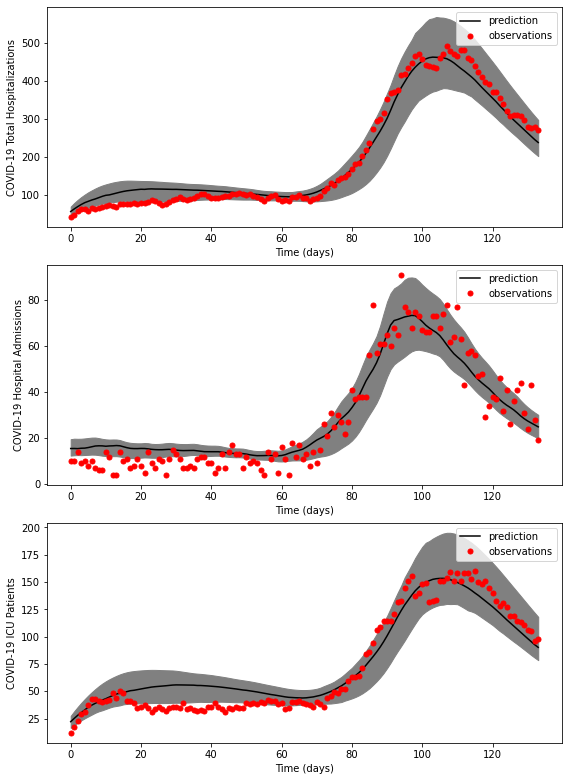

In [15]:
# Calibrator 1
cal_1 = calibrator(emu=emulator_2,
                   y=real_data,
                   x=x,
                   thetaprior=prior_covid,
                   method='directbayes',
                   yvar=obsvar, 
                   args={'theta0': np.array([[2, 4, 4, 1.875, 14, 18, 20, 14, 13, 12]]), 
                         'numsamp' : 1000,
                         'stepType' : 'normal', 
                         'stepParam' : np.array([0.01, 0.01, 0.01, 0.01, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])})

plot_pred_interval(cal_1)

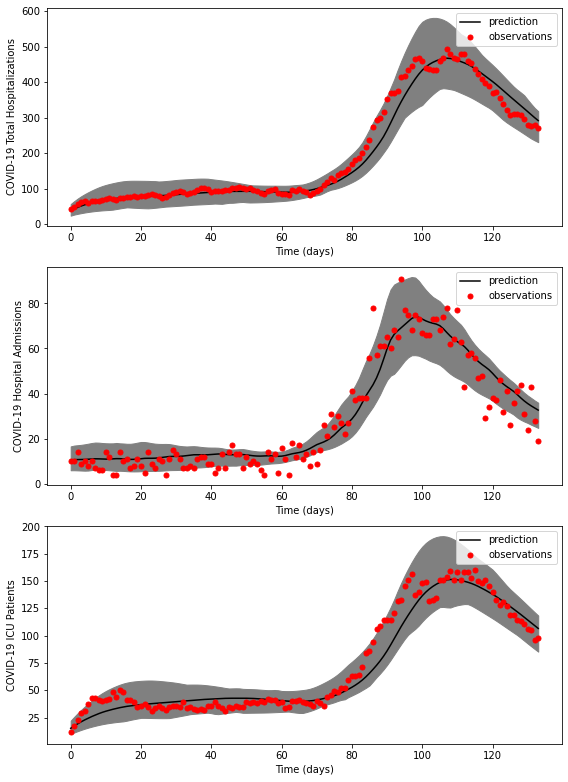

In [16]:
# Calibrator 2
cal_2 = calibrator(emu=emulator_2,
                   y=real_data,
                   x=x,
                   thetaprior=prior_covid, 
                   method='directbayes',
                   yvar=obsvar, 
                   args={'sampler': 'LMC'})

plot_pred_interval(cal_2) 

In [ ]:
# Calibrator 3
cal_3 = calibrator(emu=emulator_2,
                   y=real_data,
                   x=x,
                   thetaprior=prior_covid, 
                   method='directbayes',
                   yvar=obsvar)

plot_pred_interval(cal_3) 